In [1]:
# import warnings
# warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from SyntheticDataModule import *
from estimators import *
from utils import *

,S,d,n,True mean Y0,Impute mean Y0,Drop mean Y0,Oracle-IPCW mean Y0,True mean Y1,Impute mean Y1,Drop mean Y1,Oracle-IPCW mean Y1,True ATE,Impute ATE,Drop ATE,Oracle-IPCW ATE
0,0,1,1000,1.867505,1.868732,1.866783,1.887499,4.613728,4.579957,4.573379,4.569701,2.746223,2.711225,2.706596,2.682202
1,1,1,3000,1.793849,1.845216,1.844074,1.825465,5.995867,4.958281,5.273031,6.207076,4.202018,3.113065,3.428957,4.381611


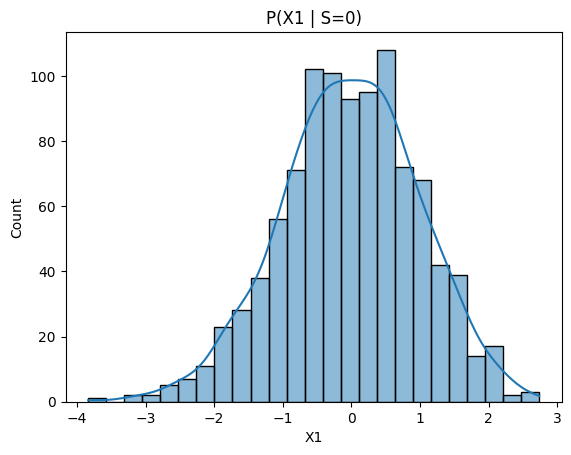

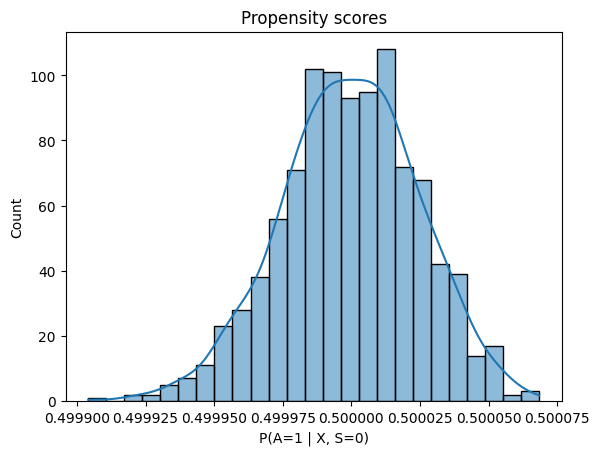

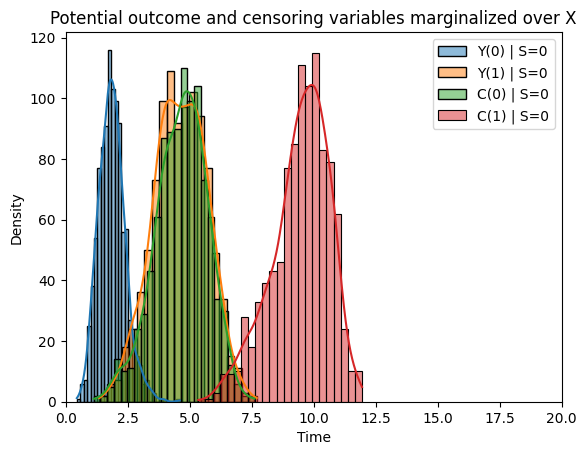

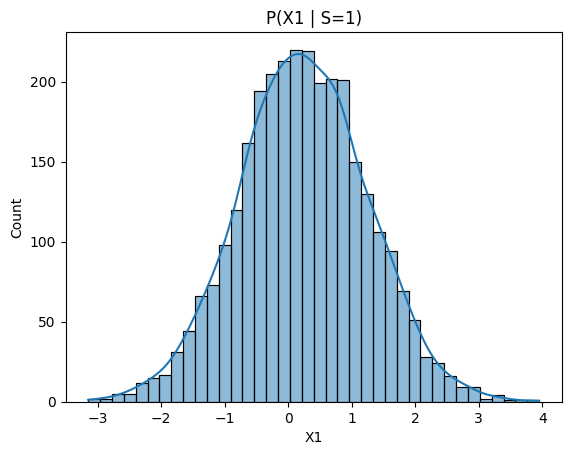

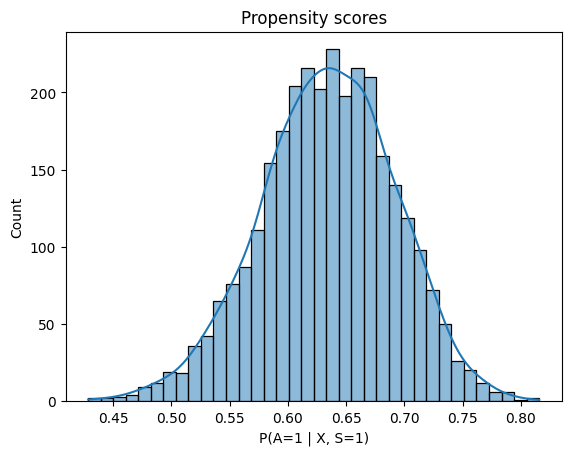

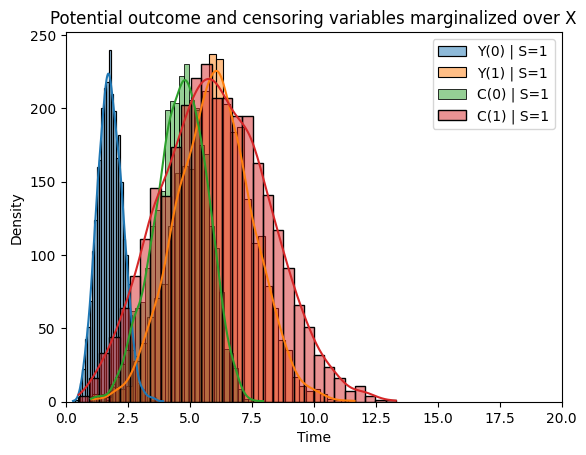

In [6]:
m = 3
with open('exp_configs/complete-IC/diff-PO_nuc/sce1.json', 'r') as file:
    try:
        jD = json.load(file)
    except json.JSONDecodeError:
        print("Invalid JSON format in the input file.")

RCTData = SyntheticDataModule(jD['save_df'], jD['cov_dim'], jD['rct_size'], 0, jD['RCT']['px_dist'], jD['RCT']['px_args'], jD['RCT']['prop_fn'], jD['RCT']['prop_args'], jD['RCT']['tte_params'])
OSData = SyntheticDataModule(jD['save_df'], jD['cov_dim'], jD['rct_size'] * m, 1, jD['OS']['px_dist'], jD['OS']['px_args'], jD['OS']['prop_fn'], jD['OS']['prop_args'], jD['OS']['tte_params'])

df_rct_oracle, df_rct = RCTData.get_df()
df_os_oracle, df_os = OSData.get_df()

df_combined = pd.concat([df_rct, df_os], axis=0, ignore_index=True)  # merge the dataframes into one
df_comb_drop = df_combined.query('Delta == 1').reset_index(drop=True).copy()  # drop the censored observations

# Estimate the nuisance parameters for the combined dataframe

df_combined['P(S=1|X)'] = prop_score_est(df_combined.copy(), 'S', jD['cov_list'], 'logistic')

df_combined.loc[df_combined.S==0, 'P(A=1|X,S)'] = prop_score_est(df_combined.query('S==0').copy(), 'A', jD['cov_list'], 'logistic')
df_combined.loc[df_combined.S==1, 'P(A=1|X,S)'] = prop_score_est(df_combined.query('S==1').copy(), 'A', jD['cov_list'], 'logistic')

cbse = gc_est(df_combined, jD['cov_list'], tte_model='coxph')

ipcw_est(df_combined, S=0)
ipcw_est(df_combined, S=1)
ipw_est(df_combined, S=0, baseline='impute')  # calling on the dataframe where censored observations are NOT dropped
ipw_est(df_combined, S=1, baseline='impute')  # calling on the dataframe where censored observations are NOT dropped

# Estimate the nuisance parameters for the combined dataframe with censored observations dropped

df_comb_drop['P(S=1|X)'] = prop_score_est(df_comb_drop.copy(), 'S', jD['cov_list'], 'logistic')

df_comb_drop.loc[df_comb_drop.S==0, 'P(A=1|X,S)'] = prop_score_est(df_comb_drop.query('S==0').copy(), 'A', jD['cov_list'], 'logistic')
df_comb_drop.loc[df_comb_drop.S==1, 'P(A=1|X,S)'] = prop_score_est(df_comb_drop.query('S==1').copy(), 'A', jD['cov_list'], 'logistic')

ipw_est(df_comb_drop, S=0, baseline='drop')  # calling on the dataframe where censored observations are dropped
ipw_est(df_comb_drop, S=1, baseline='drop')  # calling on the dataframe where censored observations are dropped

summary_df = pd.concat([RCTData.summary(plot=True), OSData.summary(plot=True)], axis=0, ignore_index=True)
summary_df

In [8]:
print('IPCW-S0-Y0: {:.2f}'.format(df_new['S0_ipcw_est_Y0'].mean()))
print('IPCW-S0-Y1: {:.2f}'.format(df_new['S0_ipcw_est_Y1'].mean()))
print('IPCW-S0-ATE: {:.2f}\n'.format(df_new['S0_ipcw_est_CATE'].mean()))

print('IPCW-S1-Y0: {:.2f}'.format(df_new['S1_ipcw_est_Y0'].mean()))
print('IPCW-S1-Y1: {:.2f}'.format(df_new['S1_ipcw_est_Y1'].mean()))
print('IPCW-S1-ATE: {:.2f}\n'.format(df_new['S1_ipcw_est_CATE'].mean()))

print('IPW-Impute-S0-Y0: {:.2f}'.format(df_new['S0_impute_ipw_est_Y0'].mean()))
print('IPW-Impute-S0-Y1: {:.2f}'.format(df_new['S0_impute_ipw_est_Y1'].mean()))
print('IPW-Impute-S0-ATE: {:.2f}\n'.format(df_new['S0_impute_ipw_est_CATE'].mean()))

print('IPW-Impute-S1-Y0: {:.2f}'.format(df_new['S1_impute_ipw_est_Y0'].mean()))
print('IPW-Impute-S1-Y1: {:.2f}'.format(df_new['S1_impute_ipw_est_Y1'].mean()))
print('IPW-Impute-S1-ATE: {:.2f}\n'.format(df_new['S1_impute_ipw_est_CATE'].mean()))

print('IPW-Drop-S0-Y0: {:.2f}'.format(df_new_drop['S0_drop_ipw_est_Y0'].mean()))
print('IPW-Drop-S0-Y1: {:.2f}'.format(df_new_drop['S0_drop_ipw_est_Y1'].mean()))
print('IPW-Drop-S0-ATE: {:.2f}\n'.format(df_new_drop['S0_drop_ipw_est_CATE'].mean()))

print('IPW-Drop-S1-Y0: {:.2f}'.format(df_new_drop['S1_drop_ipw_est_Y0'].mean()))
print('IPW-Drop-S1-Y1: {:.2f}'.format(df_new_drop['S1_drop_ipw_est_Y1'].mean()))
print('IPW-Drop-S1-ATE: {:.2f}'.format(df_new_drop['S1_drop_ipw_est_CATE'].mean()))

summary_df

IPCW-S0-Y0: 1.82
IPCW-S0-Y1: 4.51
IPCW-S0-ATE: 2.69

IPCW-S1-Y0: 1.82
IPCW-S1-Y1: 6.10
IPCW-S1-ATE: 4.29

IPW-Impute-S0-Y0: 1.81
IPW-Impute-S0-Y1: 4.51
IPW-Impute-S0-ATE: 2.69

IPW-Impute-S1-Y0: 1.82
IPW-Impute-S1-Y1: 5.01
IPW-Impute-S1-ATE: 3.19

IPW-Drop-S0-Y0: 1.81
IPW-Drop-S0-Y1: 4.50
IPW-Drop-S0-ATE: 2.69

IPW-Drop-S1-Y0: 1.82
IPW-Drop-S1-Y1: 5.37
IPW-Drop-S1-ATE: 3.55


,S,d,n,True mean Y0,Impute mean Y0,Drop mean Y0,Oracle-IPCW mean Y0,True mean Y1,Impute mean Y1,Drop mean Y1,Oracle-IPCW mean Y1,True ATE,Impute ATE,Drop ATE,Oracle-IPCW ATE
0,0,1,1000,1.867505,1.868732,1.866783,1.887499,4.613728,4.579957,4.573379,4.569701,2.746223,2.711225,2.706596,2.682202
1,1,1,3000,1.793849,1.845216,1.844074,1.825465,5.995867,4.958281,5.273031,6.207076,4.202018,3.113065,3.428957,4.381611


In [ ]:
p_thr = 0.05

df_new = df_combined[(p_thr < df_combined['P(S=1|X)']) & (df_combined['P(S=1|X)'] < 1 - p_thr) &\
            (p_thr < df_combined['P(A=1|X,S)']) & (df_combined['P(A=1|X,S)'] < 1 - p_thr)].copy().reset_index(drop=True)

df_new_drop = df_comb_drop[(p_thr < df_comb_drop['P(S=1|X)']) & (df_comb_drop['P(S=1|X)'] < 1 - p_thr) &\
            (p_thr < df_comb_drop['P(A=1|X,S)']) & (df_comb_drop['P(A=1|X,S)'] < 1 - p_thr)].copy().reset_index(drop=True)

In [7]:
df_new = df_combined
df_new_drop = df_comb_drop

In [ ]:
len(df_new)

In [ ]:
df_new.sort_values(by='P(S=1|X)')['P(S=1|X)']

In [ ]:
df_combined.sort_values(by='P(S=1|X)')

In [ ]:
x_space = np.linspace(-10,10,401)
cov_name = 'X1'
os_oracle_prop = OSData.calc_oracle_prop(x_space, cov_name)
plt.figure()
plt.plot(x_space, os_oracle_prop)
plt.xlabel(cov_name)
plt.ylabel(f'P(A=1|{cov_name},S=1)')
plt.title(f'Oracle propensity score in study S=1 wrt covariate {cov_name}')
plt.show()

t = np.linspace(0,20,101)
cov_vals = [0, 0, 0, 0]
tbs_Y0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y0')
tbs_Y1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y1')
tbs_C0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C0')
tbs_C1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C1')
plt.figure()
plt.plot(t, tbs_Y0, label='Y0', alpha= 0.4, ls ='--')
plt.plot(t, tbs_Y1, label='Y1', alpha= 1, ls ='-.')
plt.plot(t, tbs_C0, label='C0', alpha= 0.4)
plt.plot(t, tbs_C1, label='C1', alpha= 0.4)
plt.xlabel('t')
plt.ylabel(r'$S(t)$')
plt.title(f'True survival curves in study S=0 with X={cov_vals}')
plt.legend()
plt.show()

In [ ]:
t = np.linspace(0,10,101)
cov_vals = [0, 0, 0, 0]
tbs_C0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C0')

plt.figure()
plt.plot(t, tbs_C0, label='C0', alpha=0.8, ls ='--')
plt.plot(cbse['t_S0_C0'], cbse['St_S0_C0'])
plt.xlabel('t')
plt.ylabel(r'$S(t)$')
plt.title(f'True survival curves in study S=0 with X={cov_vals}')
plt.legend()
plt.show()

In [ ]:
t = np.linspace(0,10,101)
cov_vals = [0, 0, 0, 0]
tbs_C1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C1')

plt.figure()
plt.plot(t, tbs_C1, label='C1', alpha=0.8, ls ='--')
plt.plot(cbse['t_S0_C1'], cbse['St_S0_C1'])
plt.xlabel('t')
plt.ylabel(r'$S(t)$')
plt.title(f'True survival curves in study S=0 with X={cov_vals}')
plt.legend()
plt.show()

In [ ]:
t = np.linspace(0,10,101)
cov_vals = [0, 0, 0, 0]
tbs_C0 = OSData.get_oracle_surv_curve(t, cov_vals, 'C0')

plt.figure()
plt.plot(t, tbs_C0, label='C0', alpha=0.8, ls ='--')
plt.plot(cbse['t_S1_C0'], cbse['St_S1_C0'])
plt.xlabel('t')
plt.ylabel(r'$S(t)$')
plt.title(f'True survival curves in study S=0 with X={cov_vals}')
plt.legend()
plt.show()

In [ ]:
t = np.linspace(0,10,101)
cov_vals = [0, 0, 0, 0]
tbs_C1 = OSData.get_oracle_surv_curve(t, cov_vals, 'C1')

plt.figure()
plt.plot(t, tbs_C1, label='C1', alpha=0.8, ls ='--')
plt.plot(cbse['t_S1_C1'], cbse['St_S1_C1'])
plt.xlabel('t')
plt.ylabel(r'$S(t)$')
plt.title(f'True survival curves in study S=0 with X={cov_vals}')
plt.legend()
plt.show()

In [ ]:
df_combined.query('S==1 & A==1')['Delta'].mean()

In [ ]:
a = np.load('results/cic_same-po_nuc_no-cov-shift/cov_dim_2/pvals.npy')

In [ ]:
a.shape

In [ ]:
a[:,2,:]

In [ ]:
np.mean(a[:,:,:], axis=2)

In [ ]:
a[0,1,:]